In [177]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score

In [178]:
# Load Data
df = pd.read_csv('web_traffic.csv') 
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [179]:
# Create new timestamp
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month

In [180]:
df.head()

,Timestamp,TrafficCount,Hour,DayOfWeek,Month
0,2020-01-20 00:00:00,487.0,0,0,1
1,2020-01-20 00:30:00,385.0,0,0,1
2,2020-01-20 01:30:00,269.0,1,0,1
3,2020-01-20 02:30:00,517.0,2,0,1
4,2020-01-20 03:30:00,129.0,3,0,1


In [204]:
# Select features (independent variables)
#X = df[['Hour', 'DayOfWeek', 'Month']]

# Set the target variable
# We'll convert 'TrafficCount' to a binary classification: 1 = high traffic, 0 = low traffic
df['target'] = (df['TrafficCount'] > df['TrafficCount'].median()).astype(int)

In [206]:
# Keeping the split sequencial
df = df.sort_index()
split_index = int(len(df) * 0.7)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

In [208]:
# Split data into training and testing sets (70% train, 30% test)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [210]:
# Making sure the split remained sequential 
print("Train range:", train.index.min(), "to", train.index.max())
print("Test range:", test.index.min(), "to", test.index.max())

Train range: 0 to 1954
Test range: 1955 to 2792


In [216]:
X_train=train[['Hour', 'DayOfWeek', 'Month']]
y_train=train['target']
X_test=test[['Hour', 'DayOfWeek', 'Month']]
y_test=test['target']

In [218]:
rf_grid = RandomForestClassifier()
gr_space = {
    'max_depth': [3,5,7,10],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [10, 20, 30 , 40],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(rf_grid, gr_space, cv = 3, scoring='accuracy')
model_grid = grid.fit(X_train, y_train)

print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Best hyperparameters are {'max_depth': 7, 'max_features': 10, 'min_samples_leaf': 4, 'n_estimators': 100}
Best score is: 0.9641875484939012


In [220]:
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth= 7, max_features=10, min_samples_leaf=4)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

In [222]:
# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       363
           1       0.98      0.85      0.91       475

    accuracy                           0.90       838
   macro avg       0.90      0.91      0.90       838
weighted avg       0.92      0.90      0.90       838

Confusion Matrix:
[[355   8]
 [ 73 402]]


In [224]:
print("Recall score:", recall_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred))

f1_rf=f1_score(y_test, y_pred,average='weighted')
print("f1 score:",f1_rf)

Recall score: 0.8463157894736842
Precision score: 0.9804878048780488
f1 score: 0.9037631139240856


**XGBoost**

In [226]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}
Best score:  0.9652173913043478


In [228]:
xgb_model = xgb.XGBClassifier(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.5,
    random_state=42)

In [230]:
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

In [232]:
# Calculate and print the accuracy
accuracy_XGB = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       363
           1       0.98      0.83      0.90       475

    accuracy                           0.90       838
   macro avg       0.90      0.91      0.90       838
weighted avg       0.91      0.90      0.90       838

Confusion Matrix:
[[357   6]
 [ 81 394]]


In [234]:
print("Recall score:", recall_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred))

f1_XGB =f1_score(y_test, y_pred,average='weighted')
print("F1 score:",f1_XGB)

Recall score: 0.8294736842105264
Precision score: 0.985
F1 score: 0.8965924370874627


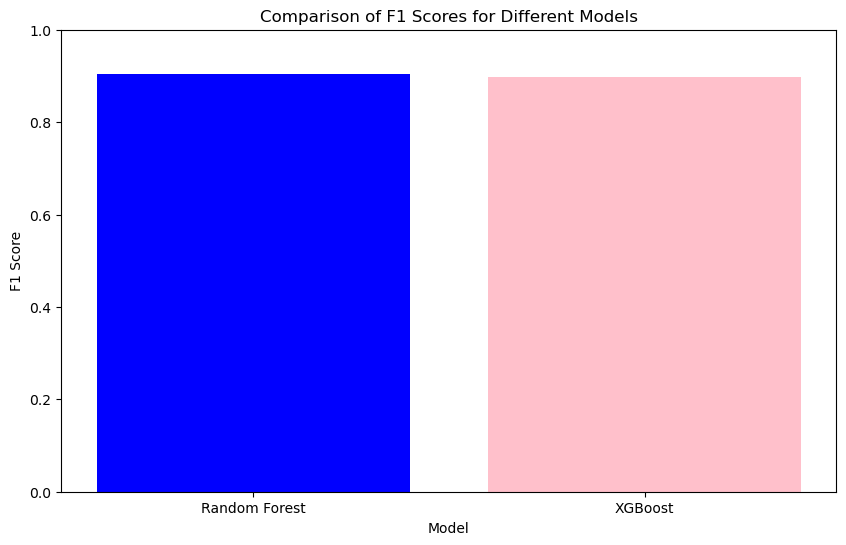

In [236]:
# F1 scores for each model
f1_scores = {
    'Random Forest': f1_rf,
    'XGBoost':f1_XGB
}

# Plotting the F1 scores
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['blue', 'pink'])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores for Different Models')
plt.ylim(0, 1)
plt.show()